In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')
df.shape



(20560, 7)

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Day,Hour,Month,Year,Data
0,23.18,27.2720,426.0,721.25,0.004793,1,4,17,2,2015,2015-02-04
1,23.15,27.2675,429.5,714.00,0.004783,1,4,17,2,2015,2015-02-04
2,23.15,27.2450,426.0,713.50,0.004779,1,4,17,2,2015,2015-02-04
3,23.15,27.2000,426.0,708.25,0.004772,1,4,17,2,2015,2015-02-04
4,23.10,27.2000,426.0,704.50,0.004757,1,4,17,2,2015,2015-02-04


In [4]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [5]:
from data_preparation import prepare_dataset

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Day,Hour,Occupancy
0,23.18,27.2720,426.0,721.25,2,17,1
1,23.15,27.2675,429.5,714.00,2,17,1
2,23.15,27.2450,426.0,713.50,2,17,1
3,23.15,27.2000,426.0,708.25,2,17,1
4,23.10,27.2000,426.0,704.50,2,17,1


PARTITIONING

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score ,cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

## knn

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [11]:
predicted_probas_knn=knn.predict_proba(X_test)

## naive bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

In [13]:
naive = GaussianNB()
naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [14]:
predicted_probas_naive=naive.predict_proba(X_test)

## logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logis = LogisticRegression(random_state=0)
logis.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
predicted_probas_logis=logis.predict_proba(X_test)

## Decision tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [20]:
predicted_probas_tree=tree.predict_proba(X_test)

## matrice con lift chart

In [22]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
import scikitplot as skplt

<Figure size 720x720 with 0 Axes>

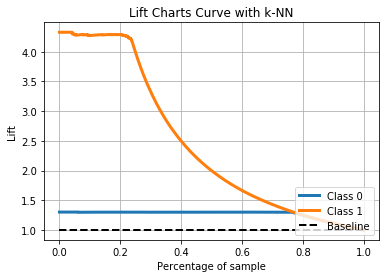

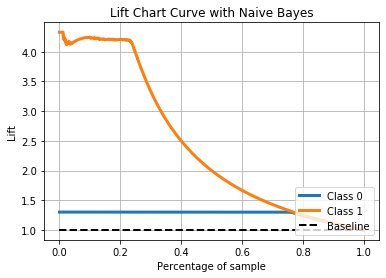

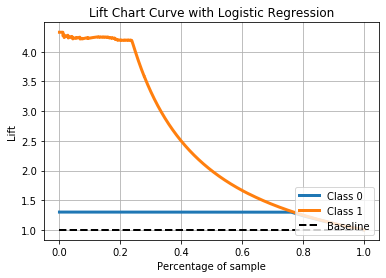

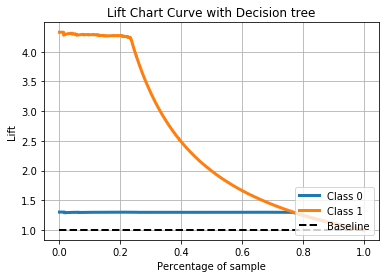

In [22]:
# Set up a grid of plots
fig = plt.figure(figsize=(10, 10)) 
fig_dims = (2,2)

# Plot death and survival counts
#plt.subplot2grid(fig_dims, (0, 0))
skplt.metrics.plot_lift_curve(y_test,predicted_probas_knn,title="Lift Charts Curve with k-NN")

plt.show()

# Plot Pclass counts
#plt.subplot2grid(fig_dims, (0, 1))
skplt.metrics.plot_lift_curve(y_test,predicted_probas_naive,title="Lift Chart Curve with Naive Bayes")
plt.show()
# Plot Sex counts
#plt.subplot2grid(fig_dims, (1, 0))
skplt.metrics.plot_lift_curve(y_test,predicted_probas_logis,title="Lift Chart Curve with Logistic Regression")
plt.show()
# Plot Embarked counts
#plt.subplot2grid(fig_dims, (1, 1))
skplt.metrics.plot_lift_curve(y_test,predicted_probas_tree,title="Lift Chart Curve with Decision tree")


plt.show()